# Предсказание дружб на графе дружб пользователей

Второе задание VK CoreML



Решение предоставил:

Илья Шамов

git: github.com/ARQtty

In [1]:
%pylab inline
rcParams['figure.figsize'] = 13, 7
import pandas as pd
import seaborn

from autograd import grad
import autograd.numpy as np
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


# Загрузка данных

По условию они разделены на 
+ 10%, которые нужно предсказать
+ (1-0.1)*0.8 * 100% = 72%, обучающая выборка
+ (1-0.1)*0.2 * 100% = 18%, тестовая выборка

Здесь и далее negative и positive будут обозначать не существующие и существующие на графе связи соответственно

In [2]:
neg_train = pd.read_csv("/home/arq/CoreML_2/divided_data/train_metriks_data.csv", " ")
pos_train = pd.read_csv("/home/arq/CoreML_2/divided_data/positive_30_percents_metriks.csv", " ")

neg_test = pd.read_csv("/home/arq/CoreML_2/divided_data/test_metriks_data.csv", " ")
# Как pos_test
must_predict_data = pd.read_csv("/home/arq/CoreML_2/divided_data/deleted_10_percent_metriks.csv", " ")

In [3]:
# Размеры датасетов
names = "neg_train neg_test pos_train must_predict_data".split()
for i, df in enumerate([neg_train, neg_test, pos_train, must_predict_data]):
    print("Size of %s:%s %d" % (names[i], " "*(len(names[-1]) - len(names[i])), len(df)))

Size of neg_train:         1791137
Size of neg_test:          447305
Size of pos_train:         338601
Size of must_predict_data: 122711


# Визуализация данных и закономерностей

## Распределение данных по метрике Adamic Adar 

Метрика считается для пары пользователей. Вычисляется множество их общих друзей, для каждого такого общего друга u вычисляется выражение 1/log(|N(u)|), где |N(u)| - мощность множества друзей u. Значения каждого общего друга суммируются, образуя AA индекс

Индекс ориентирован на 
+ увеличение важности плотных сообществ, связывающих двух пользователей (по которым вычисляется индекс). Его можно также интерпретировать как скор принадлежности пары пользователей какой-либо одной небольшой социальной группе (/кругу интересов)
+ уменьшение важности больших социальных групп. В случае большого количества общих друзей, образующих плотный граф, индекс будет меньше, чем для небольших сообществ

Таким образом, AA подходит для рекомендаций в узком кругу людей.

Ниже показано отношение индексов AA людей, у которых есть связь на соцграфе и тех, между кем её (ещё) нет. На графике видно, что AA склонен максимизироваться около нулевого значения на не связанных людях, не имеющих более 1-2 общих друзей

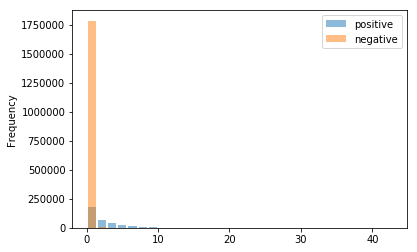

In [4]:
AA_indexes = pd.DataFrame({"positive": pos_train["AA"], 
                           "negative": neg_train["AA"]})

AA_indexes.plot.hist(bins=30, rwidth=0.8, alpha=0.5)


На графике ниже показано такое же соотношение, но взяты все индексы, большие единицы. Это показывает людей, включённых в социальные группы. Чем больше значение индекса, тем меньше социальная группа или связанность людей.

Заметим, что существует сравнительно мало ещё не созданных дружб, для которых AA > 1

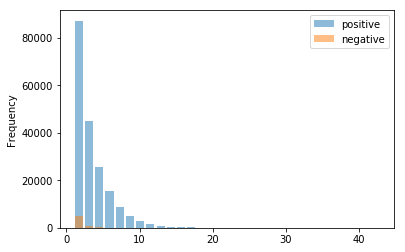

In [5]:
pd.DataFrame({"positive": pos_train.query("AA > 1")["AA"], 
              "negative": neg_train.query("AA > 1")["AA"]}, 
              ).plot.hist(bins=30, rwidth=0.8, alpha=0.5)

## Распределение данных по метрике Common Neighbours

Метрика считается для пары пользователей. Вычисляется мощность множества их общих друзей.

На графике ниже приведено сравнение распределений индекса CN для существующих и несуществующих связей. Индекс максимизируется около 0-1 для несуществующих связей, так как у многих пар кандидатов один общий друг (т.к. кандидаты искалить через друзей 2 порядка). Проверим эту гипотезу, рассморев распределение с CN > 1

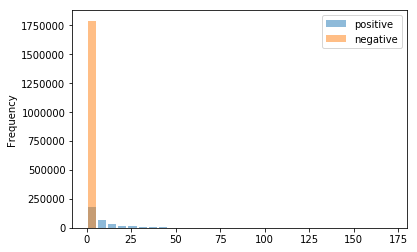

In [6]:
CN_indexs = pd.DataFrame({"positive": pos_train["CN"], 
                          "negative": neg_train["CN"]})
CN_indexs.plot.hist(bins=30, rwidth=0.8, alpha=0.5)

На распределении с CN > 1 гораздо чаще встречаются пары кандидатов, которые уже дружат

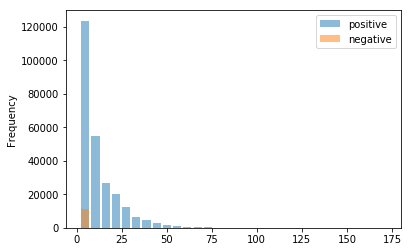

In [7]:
CN_indexs = pd.DataFrame({"positive": pos_train.query("CN>1")["CN"], 
                          "negative": neg_train.query("CN>1")["CN"]})
CN_indexs.plot.hist(bins=30, rwidth=0.8, alpha=0.5)

## Корреляция между признаками

На существующих связях индексы сильно кореллируют, на несуществующих видно постепенно растущее расхождение

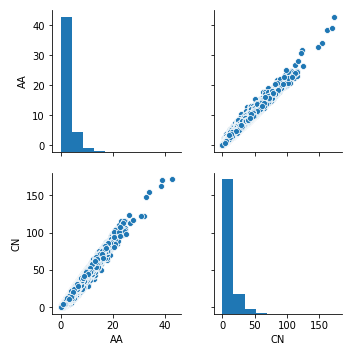

In [8]:
seaborn.pairplot(pos_train["AA CN".split()])

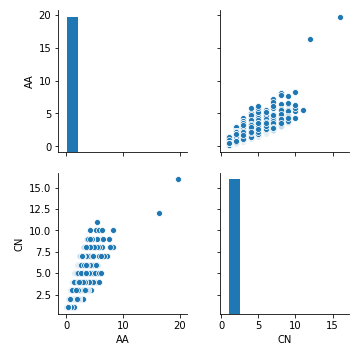

In [9]:
seaborn.pairplot(neg_train["AA CN".split()])

График рассеивания СN AA лучше всего отображает линейную разделимость классов "дружат/могут_дружить" и "не дружат". Красным обозначены не существующие связи, зелёным - существующие.

Видно, что классы сильно пересекаются у начальных значений индексов. Это значит, что модели, обученные по метрикам CN AA будут сильно ошибаться в этой области в любом случае.

Text(0,0.5,'AA')

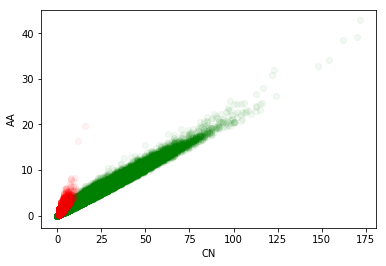

In [10]:
scatter(pos_train["CN"], pos_train["AA"], color="green", alpha=0.05)
scatter(neg_train["CN"], neg_train["AA"], color="red", alpha=0.05)
xlabel("CN")
ylabel("AA")




# Обучение модели


Подготовка данных


In [11]:
X_train = pd.concat([neg_train["CN AA".split()], pos_train["CN AA".split()]])
Y_train = [0]*len(neg_train) + [1]*len(pos_train)
Y_train = np.reshape(Y_train, (len(Y_train), 1))

X_test = pd.concat([neg_test["CN AA".split()], must_predict_data["CN AA".split()]])
Y_test = [0]*len(neg_test) + [1]*len(must_predict_data)
Y_test = np.reshape(Y_test, (len(Y_test), 1))

Следуя рекомендации из задания, использоваться будет логистическая регрессия

In [12]:
class Logit():
    
    def _sigmoid(self, z):
        
        return 1/(1+np.exp(-z))
    
    
    def _add_bias_to_data(self, features):
        b = np.ones([features.shape[0], 1])
        return np.concatenate([b, features], axis=1)
    
    
    def _bin_cross_entropy(self, actual, predicted):
        e = 1e-15
        predicted = np.clip(predicted, e, 1-e).reshape((len(predicted), 1))      
        return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))  
    
    
    def _loss_f(self, w):
        preds = np.dot(self.features, w)
        preds = preds.reshape((len(preds), 1))
        # Функция потерь
        label_probs = preds * self.answers + (1 - preds) * (1 - self.answers)
        return -np.mean(label_probs)
        
    
    def train(self, features, answers, learnRate=0.01, maxIter=50):     
        featuresSize = np.shape(features)[1]
        weights = np.zeros(featuresSize+1)
       
        print("Features number:", featuresSize)
        features = self._add_bias_to_data(features)
        
        self.answers = answers
        self.features = features
        
        
        # Grad descent

        ## Calc errors
        prediction = np.dot(features, weights)
        
        error = self._bin_cross_entropy(answers, prediction)
        print("Initial error: ", error)
        cost_deriv = grad(self._loss_f)
        
        for i in range(1, maxIter):
            ## upd weights
            delta = cost_deriv(weights)

            weights -= delta * learnRate
            
            err = self._bin_cross_entropy(answers, np.dot(features, weights))
            if i % 10 == 0:
                print("Iter",i," error:", err)

    
        print("\nWeights:", weights)
        self.weights = weights
    
    
    def predict(self, features):
        # Возвращает вероятность
        return self._sigmoid(self.weights[0] + np.dot(features, self.weights[1:]))

Из-за наложения данных разных классов друг на друга нельзя получить низкое значение ошибки

In [13]:
regr = Logit()
regr.train(np.array(X_train), np.array(Y_train), learnRate=0.01, maxIter=40)

Features number: 2
Initial error:  11694864.2261
Iter 10  error: 3114985.78147
Iter 20  error: 2997325.11574
Iter 30  error: 2951330.44362

Weights: [-0.26599001  0.22489086  0.05600107]


# Оценка качества модели

Оценка качества по AUC ROC, accuracity, полноте

## ROC кривая
Receiver Operating Characteristics кривая применяется для установления лучшего порога вероятности для классификации. Строится как отношение True Positive Rate к False Positive Rate при изменении порога вероятности для  отнесения примера к классу "дружат/могут_дружить" от 0 до 1.

Расчитывать параметры будем на тестовом датасете

In [14]:
x = np.array(X_test)
y = Y_test

# Calc probs
probs = []
for i in range(len(x)):
    pred = regr.predict(x[i])
    probs.append(pred)
    
FPR = []
TPR = []
acc = []

def calc_ROC_params(threshold):
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    for i, prob in enumerate(probs):
        if prob > threshold:
            if y[i][0] == 0:
                TP += 1
            else:
                FP += 1
        else:
            if y[i][0] == 1:
                TN += 1
            else:
                FN += 1
    
    FPR.append(TP/(TP+FN))
    TPR.append(TN/(TN+FP))
    acc.append((TP+TN)/(TP+TN+FP+FN))

t_arange = np.arange(0, 1, 0.05)
for threshold in tqdm(t_arange):
    calc_ROC_params(threshold)

100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Почему эта кривая имеет AUC около 0.1? 

Потому что модель не может обучиться хорошо разделять данные по CN AA признакам. Более того, отицательных примеров в датасете в 4 раза больше, поэтому в зоне, где есть сравнительно небольшое количество нужных пар пользователь-кандидат, модель классифицирует многие точки как положительные.

В данном случае не поможет ни l1, ни l2 регуляризация, потому что классы данных накладываются друг на друга. Максимум FPR показывает, что модель кажется правильной, когда относит почти все примеры к классу "не дружат/не могут дружить". Её можно назвать в таком случае негативно переобученной

Text(0.5,1,'Very sad ROC curve')

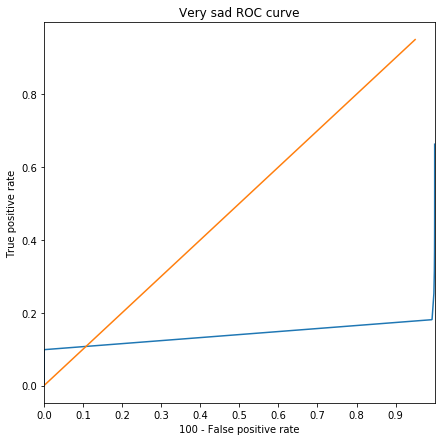

In [15]:
rcParams['figure.figsize'] = 7, 7
plt.xlim(0, 1)
plt.xticks([x for x in np.arange(0, 1, 0.1)])
plot([1-x for x in FPR], TPR)
plot([x for x in np.arange(0, 1, 0.05)], [x for x in np.arange(0, 1, 0.05)])
xlabel("100 - False positive rate")
ylabel("True positive rate")
title("Very sad ROC curve")

Также можно рассмотреть развёрнутую версию ROC curve:
+ Зависимость чувствительности (sensitivity) от порога
+ Зависимость специфичности (specificity) от порога


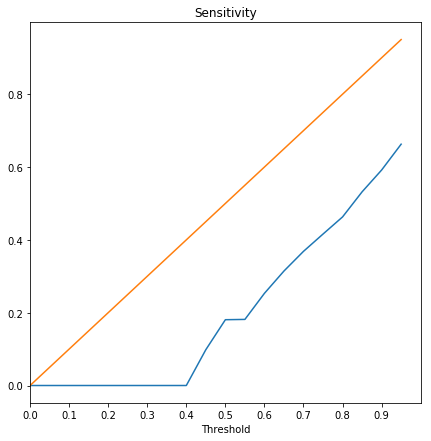

In [16]:
plt.xlim(0, 1)
title("Sensitivity")
xlabel("Threshold")
plt.xticks([x for x in np.arange(0, 1, 0.1)])
plot(t_arange, TPR)
plot([x for x in np.arange(0, 1, 0.05)], [x for x in np.arange(0, 1, 0.05)])

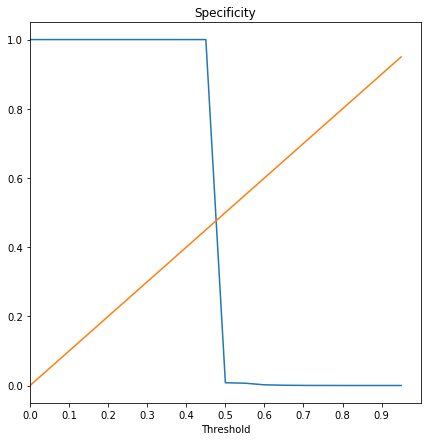

In [17]:
plt.xlim(0, 1)
title("Specificity")
xlabel("Threshold")
plt.xticks([x for x in np.arange(0, 1, 0.1)])
plot(t_arange, FPR)
plot([x for x in np.arange(0, 1, 1/len(FPR))], [x for x in np.arange(0, 1, 1/len(FPR))])

Рассмотрев модель с точки зрения параметра accuracity (точность), мы посмотрим зависимость правильно классифицированных примеров от всех классификаций с изменением порога

При переходе порога 0.45 модель начинает сильно ошибаться. До этого порога она правильно классифицирует 78% примеров.

Text(0.5,1,"Model's accuracity")

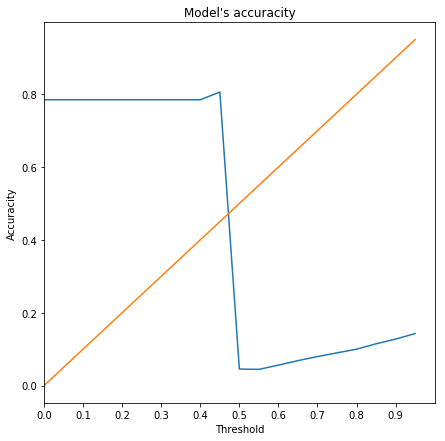

In [18]:
plt.xlim(0, 1)
plt.xticks([x for x in np.arange(0, 1, 0.1)])
plot(t_arange, acc)
plot([x for x in np.arange(0, 1, 0.05)], [x for x in np.arange(0, 1, 0.05)])
xlabel("Threshold")
ylabel("Accuracity")
title("Model's accuracity")

Снова рассмотрим график рассеивания СN AA, но разделение на классы проведёт обученная модель

In [19]:
pointsTrue = []
pointsFals = []
data = np.array(X_test)
for i in tqdm(range(0, len(data), 15)):
    # Используем оптимальный порог
    if regr.predict(data[i]) >= 0.4:
        pointsTrue.append(data[i])
    else:
        pointsFals.append(data[i])

100%|██████████| 38002/38002 [00:00<00:00, 42409.25it/s]


Что-то интересное. Модель добилась максимальной accuracity, просто относя все точки класса "дружат" к большему по мощности классу "не дружат". Теперь смысл кривой точности другой. На интервале порога 0.5 до 1 модель начинает больше делить на классы по смыслу, чем по отношению мощностей классов. Это видно на следующем графике рассеивания с порогом 0.7

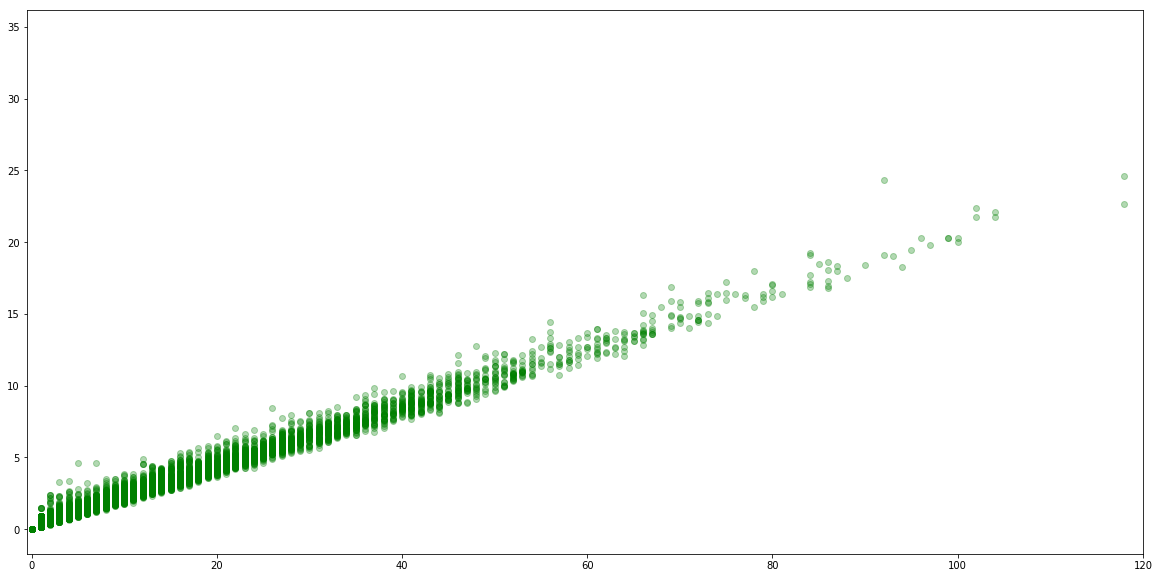

In [20]:
rcParams['figure.figsize'] = 20, 10
#xticks([x for x in range(0, 150, 3)])
#yticks([x for x in range(0, 35, 2)])
xlim(-0.5, 120)
#ylim(0, 34)
scatter([x[0] for x in pointsTrue], [x[1] for x in pointsTrue], c="green", alpha=0.3)
scatter([x[0] for x in pointsFals], [x[1] for x in pointsFals], c="red", alpha=0.3)

100%|██████████| 38002/38002 [00:00<00:00, 52827.03it/s]


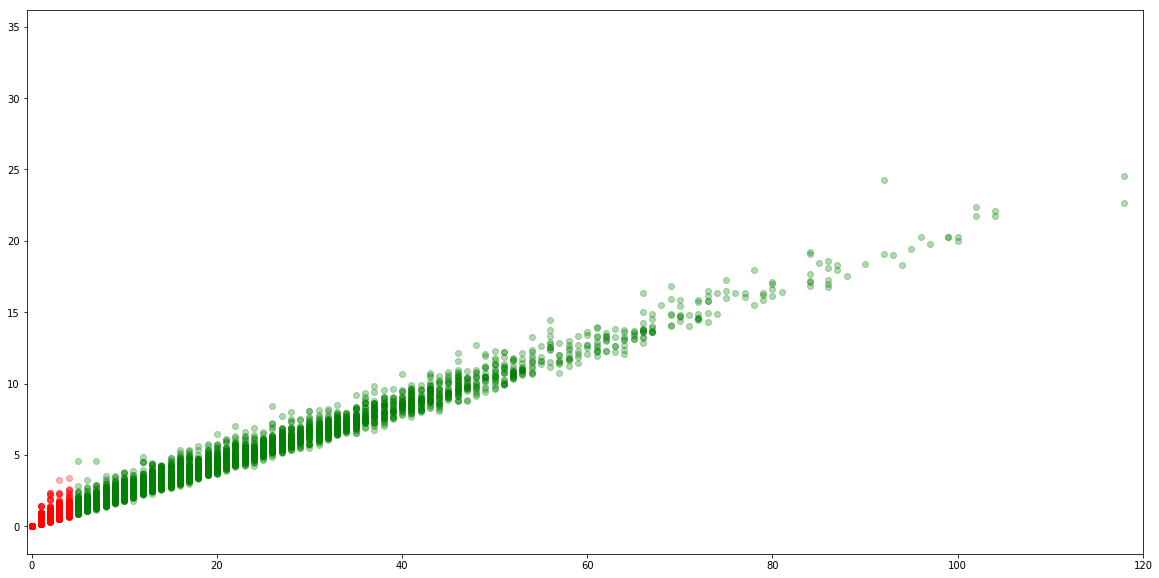

In [21]:
pointsTrue = []
pointsFals = []
data = np.array(X_test)
for i in tqdm(range(0, len(data), 15)):
    # Используем оптимальный порог
    if regr.predict(data[i]) >= 0.7:
        pointsTrue.append(data[i])
    else:
        pointsFals.append(data[i])
        
rcParams['figure.figsize'] = 20, 10
#xticks([x for x in range(0, 150, 3)])
#yticks([x for x in range(0, 35, 2)])
xlim(-0.5, 120)
#ylim(0, 34)
scatter([x[0] for x in pointsTrue], [x[1] for x in pointsTrue], c="green", alpha=0.3)
scatter([x[0] for x in pointsFals], [x[1] for x in pointsFals], c="red", alpha=0.3)

# Цель задания

Удалённые изначально рёбра хранятся в датафрейме must_predict_data, который использовался как positive примеры в тестовом датасете. Выше приведены графики, показывающие, что удалённые рёбра классифицируются как рекомендованные для пользователей. Точность выполнения задания 78%


# Выводы

Из-за перерывания классов друг другом модель не может обучиться правильно. Это можно исправить, добавив в данные признак, по которому классы не пересекаются (хотя бы не пересекаются для пользователей, у которых накладываются CN AA).

Какие это могут быть метрики?

Для предсказания связей на социальном графе (link prediction) можно использовать метрики нескольких категорий:
+ Основанные на топологии графа 
        CN и AA относятся к ним. Они основаны на соседстве вершин (обе метрики используют общих друзей). Это также могут быть метрики центральности (betweenness centrality / closeness centrality), по ним очень здорово рекомендовать публичные страницы людей. Например, политиков или художников .
+ Основанные на информации об интересах пользователя. 
        Каждая группа в ВК имеет "тематику" - обобщённый смысл группы, который для больших групп часто совпадает со смыслом контента. Так с помощью несложного NLP можно вытащить вектор интересов каждого пользователя и матчить пользователей по ним.
+ Основанные на временной составляющей графа
        В указанном в задании датасете есть данные о создании связи в графе. Это можно использовать как метрику против рекомендации. Например, у пользователя сложился социальный круг на основании поездок в детский лагерь. Какие-то из его соотрядовцев после совершеннолетия стали ездить в лагерь как вожатые, у них начинают появляться друзья. Если это небольшое количество друзей (не добавляет всех детей отряда, а только администрацию лагеря), то этих людей, наоборот, не нужно рекомендовать, потому что рёбра связей общих друзей между исходным пользователем и администрацией лагеря очень старые.

Так что же выбрать для этой модели?

Подойдёт любая метрика, не основанная на количестве общих друзей. Например, количество путей длины 2 и 3 между пользователями.